In [1]:
import controllers
import controlpy
import control_utils
import dynamics_models
import numpy as np
import polytope
import system_id
import tqdm
import uncertainty_utils
import experiment_utils

import matplotlib
import matplotlib.pyplot as plt
# matplotlib.rcParams['text.usetex'] = True
plt.rc('font', size=16)
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'large'

## SETUP

In [2]:
# Dynamics Parameters
n_states = 4
n_inputs = 2
dt = 0.1
init_state = np.array([-3.5,0, np.pi/2, 0])
linearization_state = np.zeros(n_states)
linearization_input = np.zeros(n_inputs)

# State and Input Constraints
delta_lim = np.pi / 6
a_lim = 0.3
input_limits = polytope.box2poly([[-a_lim, a_lim], [-delta_lim, delta_lim]])
state_limits = polytope.box2poly([[-4,1],[-1,1],[-5 * np.pi, 5 *np.pi],[-0.1,1]])
state_constraints = (state_limits.A, state_limits.b)
input_constraints = (input_limits.A, input_limits.b)
input_bounds = (-np.array([a_lim, delta_lim]), np.array([a_lim, delta_lim]))

# Control Task
Q = np.diag([1, 10, 1, 1]) 
R = np.eye(n_inputs)
stage_cost = lambda x, u: x.T @ Q @ x + u.T @ R @ u

num_init_episodes = 5
init_input_noise_var = 1e-3
init_input_noise = init_input_noise_var * np.eye(n_inputs)
t_inp = uncertainty_utils.calc_t(0.95, n_inputs)
idb = t_inp * np.sqrt(init_input_noise_var)
input_noise_bound = polytope.box2poly([[-idb, idb]] * n_inputs)

# Noise and Disturbances
process_noise_var = 1e-5
process_noise = process_noise_var * np.eye(n_states)
t = uncertainty_utils.calc_t(0.95, n_states)
db = t * np.sqrt(process_noise_var)
disturbance_bound = polytope.box2poly([[-db, db]] * n_states)

# Experiment Details
episode_length = int(10 / dt)
controller_horizon = 5
state_reference = np.zeros(n_states)
num_episodes = 10



# System ID
h = 2
lamb = 1e-2
n_sysid_pts = 300
n_sysid_it = 5

def model_callback(model, controller, episode_length):
    As, Bs, Cs, covs, errors = model.regress_models(controller.x_traj.value.T, controller.u_traj.value.T)
    return As, Bs, Cs, covs, errors

# Save Results
save_dir = "dubin_car_expts/"
save_data = False

# Vehicle
def get_vehicle():
    vehicle = dynamics_models.DubinCar(init_state, dt, process_noise, use_ode_integrator=False)
    return vehicle

def sim_traj(vehicle, controller, input_limits, episode_length=episode_length, model=None, model_callback=None, input_noise=None):
    x_traj = [vehicle.x]
    u_traj = []
    
    x_pred_trajs = []
    u_pred_trajs = []
    model_covs = []
    
    slacks = []
    terminal_slacks = []
    
    for _ in tqdm.tqdm(range(episode_length)):
        u_command = controller.solve(x_traj[-1])
        if u_command is None:
            print("controller error at iteration %d" %_)
            print("state:")
            print(x_traj[-1])
            break
        if input_noise is not None: 
            u_noise = np.random.multivariate_normal(np.zeros(input_limits[0].shape), input_noise)
            u_command = u_command + u_noise
        if model is not None:
            As, Bs, Cs, covs, errors = model_callback(model, controller, episode_length)
            controller.set_models(As, Bs, Cs)
            model_covs.append(covs)
        u = np.minimum(np.maximum(input_limits[0], u_command), input_limits[1])
        x_next = vehicle.f(u)

        x_traj.append(x_next)
        u_traj.append(u)
        
        x_pred_trajs.append(controller.x_traj.value.T)
        u_pred_trajs.append(controller.u_traj.value.T)
        
        slacks.append(controller.slack.value)
        terminal_slacks.append(controller.terminal_slack.value)
        
    return np.array(x_traj), np.array(u_traj), x_pred_trajs, u_pred_trajs, slacks, terminal_slacks, model_covs

## Plotting
l = 0.125
w = 0.075
figsize = (8,4)
state_lims_proj = state_limits.project([1,2])

def plot_experiment(traj_list, x_preds, ax, xlims=(-5,2), ylims=(-1.5, 1.5), lw=2, k=10):
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_xlabel("x in (m)")
    ax.set_ylabel("y in (m)")
    state_lims_proj.plot(ax=ax, alpha=1, color="w", edgecolor="b", linewidth=lw)
    
    for x_traj in traj_list:
        ax.plot(x_traj[0,:], x_traj[1,:], "r--")
        
    for pred in x_preds:
        ax.plot(pred[:,0], pred[:,1], color="tab:blue", linestyle="--", alpha=0.6)
        
    x_traj = traj_list[-1].T
    ax.plot(x_traj[:,0], x_traj[:,1], "k", lw=lw)
    patches = [dynamics_models.plot_vehicle(x[:3], l, w, alpha=0.4) for x in np.rollaxis(x_traj[::k,:],0)]
    for patch in patches:
        ax.add_patch(patch)

## Initial Trajectories With Tracking MPC

In [3]:
vehicle = get_vehicle()
A, B, C = vehicle.get_linearization(linearization_state, linearization_input, dt)
A[1,2] = 0.025

init_state_limits = control_utils.pontryagin_difference(state_limits, disturbance_bound)
init_input_limits = control_utils.pontryagin_difference(input_limits, input_noise_bound)
init_state_constraints = (init_state_limits.A, init_state_limits.b)
init_input_constraints = (init_input_limits.A, init_input_limits.b)

controller = controllers.LTI_MPC_Tracker(A, B, C,
                                         controller_horizon * 2, 
                                         Q, 3*R, state_reference, 
                                         init_state_constraints, init_input_constraints)
controller.build()

In [4]:
x_init_trajs = []
u_init_trajs = []
for _ in range(num_init_episodes):
    vehicle = get_vehicle()
    x_init_traj, u_init_traj, x_init_preds, u_init_preds, slacks, terminal_slacks, model_covs = sim_traj(vehicle, controller, input_bounds, input_noise=init_input_noise)
    x_init_trajs.append(x_init_traj)
    u_init_trajs.append(u_init_traj)
init_value_functions = [control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, stage_cost) for x_traj, u_traj in zip(x_init_trajs, u_init_trajs)]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

10.78094219736382
12.33956346883118


  2%|█▋                                                                                | 2/100 [00:00<00:08, 11.31it/s]

12.93975152788447
11.795702220884811


  4%|███▎                                                                              | 4/100 [00:00<00:08, 11.63it/s]

11.458375563793721
13.19374270606258


  6%|████▉                                                                             | 6/100 [00:00<00:08, 11.72it/s]

13.549856887183164
9.370840789917581


  8%|██████▌                                                                           | 8/100 [00:00<00:08, 11.47it/s]

11.93662719384372
6.151746755313454


 10%|████████                                                                         | 10/100 [00:00<00:08, 10.53it/s]

7.5101865413746545


 11%|████████▉                                                                        | 11/100 [00:01<00:08, 10.13it/s]

10.893701901974177
11.936864992856615


 13%|██████████▌                                                                      | 13/100 [00:01<00:08, 10.28it/s]

11.716194775302242
11.789932902884868


 15%|████████████▏                                                                    | 15/100 [00:01<00:08, 10.41it/s]

9.549328931640959


 16%|████████████▉                                                                    | 16/100 [00:01<00:08, 10.32it/s]

6.468857960714638


 17%|█████████████▊                                                                   | 17/100 [00:01<00:08,  9.94it/s]

8.862241642332837


 18%|██████████████▌                                                                  | 18/100 [00:01<00:08,  9.85it/s]

8.68040861603669


 19%|███████████████▍                                                                 | 19/100 [00:01<00:08,  9.77it/s]

8.212531328320802


 20%|████████████████▏                                                                | 20/100 [00:02<00:08,  9.66it/s]

8.835619670363005


 21%|█████████████████                                                                | 21/100 [00:02<00:08,  9.60it/s]

8.996810374968629


 22%|█████████████████▊                                                               | 22/100 [00:02<00:08,  9.55it/s]

11.091288918505825
11.725496773904974


 24%|███████████████████▍                                                             | 24/100 [00:02<00:07,  9.66it/s]

8.425917964747903


 25%|████████████████████▎                                                            | 25/100 [00:02<00:07,  9.59it/s]

10.337061372161457


 26%|█████████████████████                                                            | 26/100 [00:02<00:07,  9.60it/s]

12.770847796168415
9.8300928095997


 28%|██████████████████████▋                                                          | 28/100 [00:02<00:07,  9.68it/s]

9.152553320560548


 29%|███████████████████████▍                                                         | 29/100 [00:03<00:07,  9.65it/s]

9.637182029359797


 30%|████████████████████████▎                                                        | 30/100 [00:03<00:07,  9.64it/s]

9.115159101676424


 31%|█████████████████████████                                                        | 31/100 [00:03<00:07,  9.61it/s]

11.589932908160446
10.717608669543909


 33%|██████████████████████████▋                                                      | 33/100 [00:03<00:06,  9.67it/s]

8.93732394066081


 34%|███████████████████████████▌                                                     | 34/100 [00:03<00:06,  9.64it/s]

11.103591595343925
13.005150211930756


 36%|█████████████████████████████▏                                                   | 36/100 [00:03<00:06,  9.73it/s]

12.233677216500558
13.277777953648275


 38%|██████████████████████████████▊                                                  | 38/100 [00:03<00:06,  9.84it/s]

12.855000950110028
10.790316688533869


 40%|████████████████████████████████▍                                                | 40/100 [00:04<00:06,  9.91it/s]

10.482274643680976
9.02569576098488


 42%|██████████████████████████████████                                               | 42/100 [00:04<00:05,  9.89it/s]

14.124994106593206
14.854455305284034


 44%|███████████████████████████████████▋                                             | 44/100 [00:04<00:05, 10.02it/s]

11.516295722750312
10.441488090496296


 46%|█████████████████████████████████████▎                                           | 46/100 [00:04<00:05, 10.05it/s]

6.488893564486635
10.609332196761782


 48%|██████████████████████████████████████▉                                          | 48/100 [00:04<00:05,  9.93it/s]

12.227043887649948
11.130789236240116


 50%|████████████████████████████████████████▌                                        | 50/100 [00:05<00:05,  9.98it/s]

11.221647595172419
11.864269469682398


 52%|██████████████████████████████████████████                                       | 52/100 [00:05<00:04, 10.02it/s]

12.512541466790768
13.192871207403075


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:05<00:04, 10.09it/s]

14.206181307050077
13.279585620840535


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:05<00:04, 10.18it/s]

12.394075860194082
8.988134550807995


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:05<00:04, 10.18it/s]

13.022068228953218
9.610330929779098


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:05<00:03, 10.19it/s]

8.680480475508498
10.336832091639701


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:06<00:03, 10.15it/s]

11.885921559737021
10.5501953179041


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:06<00:03, 10.18it/s]

9.967713034323616
9.925373416882797


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:06<00:03, 10.16it/s]

6.4274019792634
7.110158788817823


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:06<00:03,  9.99it/s]

11.13528093705863
11.52518788211857


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:06<00:02, 10.02it/s]

11.506059857899213
12.173493080709575


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:07<00:02, 10.06it/s]

11.32952648496799
8.643789967418117


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:07<00:02, 10.04it/s]

9.877898802444568
9.62607895383076


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:07<00:02, 10.02it/s]

8.116635768663619


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:07<00:02,  9.99it/s]

10.103299593873903


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:07<00:02,  9.99it/s]

9.68670380326839


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:07<00:02,  9.97it/s]

10.330569026794972


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:08<00:02,  9.97it/s]

10.885022630071004
10.07413100705186


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:08<00:01,  9.97it/s]

10.337418050968601


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:08<00:01,  9.97it/s]

11.659135385162783
10.95069931621834


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:08<00:01, 10.00it/s]

12.15106321339591
10.283105694525146


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:08<00:01, 10.01it/s]

12.448591695604428
9.26791025318078


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:08<00:01, 10.02it/s]

13.541632497562425
11.618377533891403


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:09<00:00, 10.06it/s]

8.18924892418953
10.444582234540325


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:09<00:00, 10.03it/s]

13.087201120787297
12.681382938517588


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:09<00:00, 10.07it/s]

12.76509544215037
12.080542634542548


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:09<00:00, 10.10it/s]

9.07367009194159
12.533105438985471


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:09<00:00, 10.10it/s]

11.936831020988972


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

14.021160589822191
13.197479004817328


  2%|█▋                                                                                | 2/100 [00:00<00:07, 13.30it/s]

11.393942686700152
9.773560636423797


  4%|███▎                                                                              | 4/100 [00:00<00:08, 11.55it/s]

13.36808656435754
13.006924739585756


  6%|████▉                                                                             | 6/100 [00:00<00:07, 11.93it/s]

11.725332878592615
10.56715349983246


  8%|██████▌                                                                           | 8/100 [00:00<00:07, 11.61it/s]

8.151750730766839


  9%|███████▍                                                                          | 9/100 [00:00<00:08, 11.05it/s]

10.271823594094007


 10%|████████                                                                         | 10/100 [00:00<00:08, 10.93it/s]

10.178965965791058


 11%|████████▉                                                                        | 11/100 [00:01<00:08, 10.83it/s]

10.399315688340668
11.635814850262856


 13%|██████████▌                                                                      | 13/100 [00:01<00:08, 10.80it/s]

10.220885745895128
10.73071540592884


 15%|████████████▏                                                                    | 15/100 [00:01<00:07, 10.72it/s]

11.010348031983872
10.497727409246542


 17%|█████████████▊                                                                   | 17/100 [00:01<00:07, 10.69it/s]

7.708388927483175
7.530195799625852


 19%|███████████████▍                                                                 | 19/100 [00:01<00:07, 10.21it/s]

7.70947991434532


 20%|████████████████▏                                                                | 20/100 [00:01<00:07, 10.03it/s]

10.727284817669837
10.778116407554927


 22%|█████████████████▊                                                               | 22/100 [00:02<00:07, 10.07it/s]

11.658552042739366
10.710465567608425


 24%|███████████████████▍                                                             | 24/100 [00:02<00:07, 10.13it/s]

9.473258167100319


 25%|████████████████████▎                                                            | 25/100 [00:02<00:07, 10.09it/s]

10.662328154234118
11.389239930594213


 27%|█████████████████████▊                                                           | 27/100 [00:02<00:07, 10.13it/s]

10.839479308535795
10.468330230166773


 29%|███████████████████████▍                                                         | 29/100 [00:02<00:06, 10.15it/s]

11.013296922592165
11.844970347359503


 31%|█████████████████████████                                                        | 31/100 [00:03<00:06, 10.21it/s]

11.616414682039622
11.442839058885154


 33%|██████████████████████████▋                                                      | 33/100 [00:03<00:06, 10.27it/s]

12.24853913028242
10.749416308506904


 35%|████████████████████████████▎                                                    | 35/100 [00:03<00:06, 10.32it/s]

11.930549550574582
10.952443622766062


 37%|█████████████████████████████▉                                                   | 37/100 [00:03<00:06, 10.36it/s]

8.37632830270823
10.304579726950886


 39%|███████████████████████████████▌                                                 | 39/100 [00:03<00:05, 10.28it/s]

11.51670680106427
11.720647411249217


 41%|█████████████████████████████████▏                                               | 41/100 [00:03<00:05, 10.33it/s]

10.961230788529436
10.63761191001547


 43%|██████████████████████████████████▊                                              | 43/100 [00:04<00:05, 10.34it/s]

9.198902528089272
9.969039747298167


 45%|████████████████████████████████████▍                                            | 45/100 [00:04<00:05, 10.28it/s]

10.99484899561968
10.49090054126522


 47%|██████████████████████████████████████                                           | 47/100 [00:04<00:05, 10.29it/s]

11.937068828123222
10.07260684858804


 49%|███████████████████████████████████████▋                                         | 49/100 [00:04<00:04, 10.30it/s]

10.026160789413295
10.597376871903322


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:04<00:04, 10.29it/s]

12.065842390209943
11.64916178774177


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:05<00:04, 10.33it/s]

8.935952992709439
11.590221148824345


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:05<00:04, 10.31it/s]

11.01292099576477
12.146453486856775


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:05<00:04, 10.35it/s]

12.227685508298423
12.080820998482086


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:05<00:03, 10.39it/s]

10.891778264245408
11.018765220635174


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:05<00:03, 10.40it/s]

11.394376030621864
10.66278895360218


 63%|███████████████████████████████████████████████████                              | 63/100 [00:06<00:03, 10.41it/s]

11.848517206506324
12.083222420041599


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:06<00:03, 10.44it/s]

11.584587042443358
11.525029538647543


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:06<00:03, 10.47it/s]

10.439357057877734
8.154429104963654


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:06<00:02, 10.42it/s]

7.192976980369089
10.421097092540785


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:06<00:02, 10.34it/s]

10.7754028280171
10.946041025105695


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:07<00:02, 10.35it/s]

11.203273661661084
11.140220079096736


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:07<00:02, 10.36it/s]

10.27031447803698
11.522939812525413


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:07<00:02, 10.37it/s]

11.184542237652963
11.605068894914504


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:07<00:02, 10.39it/s]

11.718256972751579
10.282248594689605


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:07<00:01, 10.39it/s]

11.09842056101969
12.06872401340872


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:07<00:01, 10.41it/s]

11.135251374549007
12.157579095349208


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:08<00:01, 10.43it/s]

11.74720414959375
11.796266192675258


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:08<00:01, 10.45it/s]

10.714186455225406
9.620956291360347


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:08<00:01, 10.44it/s]

7.876937869850266
8.249553525769628


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:08<00:00, 10.37it/s]

9.975299011342097


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:08<00:00, 10.36it/s]

10.021896519590742


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:08<00:00, 10.35it/s]

9.45917895586713


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:09<00:00, 10.34it/s]

8.392384573057877


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:09<00:00, 10.31it/s]

8.352525091604269


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:09<00:00, 10.28it/s]

9.975773518310188


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:09<00:00, 10.27it/s]

10.27713417622268
10.499724633762904


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:09<00:00, 10.27it/s]

9.459264287663478


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

9.453997935327981


  1%|▊                                                                                 | 1/100 [00:00<00:10,  9.28it/s]

10.609466377967097
9.370819853795421


  3%|██▍                                                                               | 3/100 [00:00<00:10,  9.56it/s]

8.850012238042588


  4%|███▎                                                                              | 4/100 [00:00<00:10,  9.31it/s]

6.039497234617605


  5%|████                                                                              | 5/100 [00:00<00:11,  8.33it/s]

8.195569554708399


  6%|████▉                                                                             | 6/100 [00:00<00:11,  8.25it/s]

10.27600112699521


  7%|█████▋                                                                            | 7/100 [00:00<00:10,  8.45it/s]

10.087869218355031


  8%|██████▌                                                                           | 8/100 [00:00<00:10,  8.59it/s]

7.923618379044171


  9%|███████▍                                                                          | 9/100 [00:01<00:10,  8.49it/s]

9.548481095650907


 10%|████████                                                                         | 10/100 [00:01<00:10,  8.56it/s]

10.845309110278508
11.329465279353451


 12%|█████████▋                                                                       | 12/100 [00:01<00:09,  8.86it/s]

9.776864031253861


 13%|██████████▌                                                                      | 13/100 [00:01<00:09,  8.91it/s]

11.4401237211256
11.379413815462835


 15%|████████████▏                                                                    | 15/100 [00:01<00:09,  9.14it/s]

11.201358807411482
8.756448905627604


 17%|█████████████▊                                                                   | 17/100 [00:01<00:09,  9.18it/s]

7.957094751619666


 18%|██████████████▌                                                                  | 18/100 [00:01<00:09,  9.07it/s]

8.149184946278343


 19%|███████████████▍                                                                 | 19/100 [00:02<00:09,  8.99it/s]

9.503351081907782


 20%|████████████████▏                                                                | 20/100 [00:02<00:08,  9.01it/s]

7.715351037744353


 21%|█████████████████                                                                | 21/100 [00:02<00:08,  8.92it/s]

10.59697525530442
9.790145674465071


 23%|██████████████████▋                                                              | 23/100 [00:02<00:08,  9.00it/s]

10.609949458410696
11.598426002483222


 25%|████████████████████▎                                                            | 25/100 [00:02<00:08,  9.12it/s]

10.780360295988629
11.016160592108546


 27%|█████████████████████▊                                                           | 27/100 [00:02<00:07,  9.21it/s]

9.144232509162102


 28%|██████████████████████▋                                                          | 28/100 [00:03<00:07,  9.20it/s]

9.977766940634924


 29%|███████████████████████▍                                                         | 29/100 [00:03<00:07,  9.22it/s]

10.229785199837076


 30%|████████████████████████▎                                                        | 30/100 [00:03<00:07,  9.24it/s]

9.828480374926771


 31%|█████████████████████████                                                        | 31/100 [00:03<00:07,  9.25it/s]

11.002405454111438
10.498147814421017


 33%|██████████████████████████▋                                                      | 33/100 [00:03<00:07,  9.31it/s]

9.733867411777265


 34%|███████████████████████████▌                                                     | 34/100 [00:03<00:07,  9.31it/s]

8.355803116962804


 35%|████████████████████████████▎                                                    | 35/100 [00:03<00:07,  9.27it/s]

6.581602662578439


 36%|█████████████████████████████▏                                                   | 36/100 [00:03<00:06,  9.16it/s]

7.5252915076584115


 37%|█████████████████████████████▉                                                   | 37/100 [00:04<00:06,  9.10it/s]

8.950330758396996


 38%|██████████████████████████████▊                                                  | 38/100 [00:04<00:06,  9.09it/s]

8.17142779214049


 39%|███████████████████████████████▌                                                 | 39/100 [00:04<00:06,  9.05it/s]

6.595356853076038


 40%|████████████████████████████████▍                                                | 40/100 [00:04<00:06,  8.96it/s]

8.955567038044522


 41%|█████████████████████████████████▏                                               | 41/100 [00:04<00:06,  8.95it/s]

9.331271733012377


 42%|██████████████████████████████████                                               | 42/100 [00:04<00:06,  8.95it/s]

9.867720025502702


 43%|██████████████████████████████████▊                                              | 43/100 [00:04<00:06,  8.96it/s]

10.858505342132037
9.371929597197116


 45%|████████████████████████████████████▍                                            | 45/100 [00:05<00:06,  9.00it/s]

9.68453426862129


 46%|█████████████████████████████████████▎                                           | 46/100 [00:05<00:05,  9.01it/s]

11.463386236734292
11.007949609605669


 48%|██████████████████████████████████████▉                                          | 48/100 [00:05<00:05,  9.07it/s]

11.719435697261472
10.646252252709598


 50%|████████████████████████████████████████▌                                        | 50/100 [00:05<00:05,  9.13it/s]

10.146855041610218
9.499519849250783


 52%|██████████████████████████████████████████                                       | 52/100 [00:05<00:05,  9.15it/s]

7.4023094802345835


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:05<00:05,  9.10it/s]

9.683081000466343


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:05<00:05,  9.11it/s]

8.500491468711177


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:06<00:04,  9.09it/s]

10.27801560949312


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:06<00:04,  9.11it/s]

9.522315884587181


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:06<00:04,  9.11it/s]

9.413640485146649


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:06<00:04,  9.11it/s]

9.209567243192682


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:06<00:04,  9.10it/s]

8.276021010177544


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:06<00:04,  9.08it/s]

9.49261851899631


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:06<00:04,  9.09it/s]

8.085904094324855


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:06<00:04,  9.06it/s]

7.767603625359739


 63%|███████████████████████████████████████████████████                              | 63/100 [00:06<00:04,  9.03it/s]

7.9721432372842695


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:07<00:03,  9.00it/s]

10.440552408073044
10.194131386364575


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:07<00:03,  9.03it/s]

11.265895068774997
8.117908232092638


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:07<00:03,  9.04it/s]

9.87780575056698


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:07<00:03,  9.05it/s]

9.83000065622334


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:07<00:03,  9.05it/s]

7.4708712356680635


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:07<00:03,  9.02it/s]

8.475533067136553


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:07<00:03,  9.01it/s]

9.06631504998649


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:08<00:02,  9.01it/s]

10.119778220650186


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:08<00:02,  9.02it/s]

10.180151841711812


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:08<00:02,  9.03it/s]

10.713967507918667
11.068429816621498


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:08<00:02,  9.06it/s]

10.175903731379494


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:08<00:02,  9.07it/s]

8.604406515406392


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:08<00:02,  9.06it/s]

9.383755243581856


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:08<00:02,  9.06it/s]

9.91106679206227


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:08<00:02,  9.07it/s]

8.086480900592079


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:09<00:01,  9.05it/s]

10.22761499746401


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:09<00:01,  9.06it/s]

10.489693635113168
6.684448070989622


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:09<00:01,  9.04it/s]

8.390151787928978


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:09<00:01,  9.02it/s]

9.458901638161219


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:09<00:01,  9.03it/s]

10.277587465878629


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:09<00:01,  9.03it/s]

8.830820149822513


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:09<00:01,  9.03it/s]

10.78110846643807
8.949356798265734


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:10<00:00,  9.04it/s]

10.380887088191544
10.639689710892334


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:10<00:00,  9.06it/s]

9.917441041137609


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:10<00:00,  9.06it/s]

11.46987530080945
11.347580359341055


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:10<00:00,  9.10it/s]

9.97631925713443


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:10<00:00,  9.10it/s]

10.018999844733479


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:10<00:00,  9.11it/s]

11.389209004263176
11.106737705091676


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

7.769459752336319


  1%|▊                                                                                 | 1/100 [00:00<00:12,  7.71it/s]

10.383868292381011


  2%|█▋                                                                                | 2/100 [00:00<00:11,  8.70it/s]

10.48510468095744
10.393466021727063


  4%|███▎                                                                              | 4/100 [00:00<00:10,  9.38it/s]

12.378676221029238
11.932653955356788


  6%|████▉                                                                             | 6/100 [00:00<00:09, 10.08it/s]

11.721204228717385
11.864269469682398


  8%|██████▌                                                                           | 8/100 [00:00<00:08, 10.39it/s]

11.394035543337118
8.425985672442957


 10%|████████                                                                         | 10/100 [00:00<00:08, 10.16it/s]

7.741224848379702


 11%|████████▉                                                                        | 11/100 [00:01<00:09,  9.85it/s]

10.236900938192539


 12%|█████████▋                                                                       | 12/100 [00:01<00:08,  9.85it/s]

11.351941517650529
10.60471842897705


 14%|███████████▎                                                                     | 14/100 [00:01<00:08,  9.97it/s]

10.614997595727989
8.833461101048819


 16%|████████████▉                                                                    | 16/100 [00:01<00:08,  9.90it/s]

11.141492543656929
12.111134852938628


 18%|██████████████▌                                                                  | 18/100 [00:01<00:08, 10.03it/s]

11.923291658849147
11.795304155616988


 20%|████████████████▏                                                                | 20/100 [00:01<00:07, 10.17it/s]

10.336832091639701
9.94349168116753


 22%|█████████████████▊                                                               | 22/100 [00:02<00:07, 10.14it/s]

10.93787715208128
11.140871071162003


 24%|███████████████████▍                                                             | 24/100 [00:02<00:07, 10.20it/s]

10.554628953924356
10.659374563198089


 26%|█████████████████████                                                            | 26/100 [00:02<00:07, 10.21it/s]

11.20222639463486
11.392116813697797


 28%|██████████████████████▋                                                          | 28/100 [00:02<00:07, 10.26it/s]

11.885079553987618
12.498708202837484


 30%|████████████████████████▎                                                        | 30/100 [00:02<00:06, 10.35it/s]

11.658778891189838
10.127132905967429


 32%|█████████████████████████▉                                                       | 32/100 [00:03<00:06, 10.37it/s]

7.624205187864686
10.387880198826556


 34%|███████████████████████████▌                                                     | 34/100 [00:03<00:06, 10.25it/s]

7.8334513059475
7.398483720634876


 36%|█████████████████████████████▏                                                   | 36/100 [00:03<00:06, 10.04it/s]

9.033432477078842


 37%|█████████████████████████████▉                                                   | 37/100 [00:03<00:06, 10.00it/s]

10.3891667223985


 38%|██████████████████████████████▊                                                  | 38/100 [00:03<00:06, 10.00it/s]

9.83016192576586


 39%|███████████████████████████████▌                                                 | 39/100 [00:03<00:06,  9.98it/s]

11.32866966653882
9.549285449209634


 41%|█████████████████████████████████▏                                               | 41/100 [00:04<00:05,  9.99it/s]

10.608312530508702
9.413724997306712


 43%|██████████████████████████████████▊                                              | 43/100 [00:04<00:05,  9.98it/s]

9.518382945310709


 44%|███████████████████████████████████▋                                             | 44/100 [00:04<00:05,  9.96it/s]

9.198700783170711


 45%|████████████████████████████████████▍                                            | 45/100 [00:04<00:05,  9.93it/s]

9.370882662442554


 46%|█████████████████████████████████████▎                                           | 46/100 [00:04<00:05,  9.91it/s]

10.666829429566898
11.24047349139606


 48%|██████████████████████████████████████▉                                          | 48/100 [00:04<00:05,  9.94it/s]

7.7726560950886086


 49%|███████████████████████████████████████▋                                         | 49/100 [00:04<00:05,  9.88it/s]

8.852832848932312


 50%|████████████████████████████████████████▌                                        | 50/100 [00:05<00:05,  9.85it/s]

10.964812665349102
10.026759994358265


 52%|██████████████████████████████████████████                                       | 52/100 [00:05<00:04,  9.86it/s]

10.440604386030419
10.645846923106209


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:05<00:04,  9.87it/s]

10.23000975609756
10.44479031000899


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:05<00:04,  9.88it/s]

10.554469597076972
8.875406283856988


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:05<00:04,  9.87it/s]

8.330974319656615


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:06<00:04,  9.83it/s]

7.427543315341352


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:06<00:04,  9.77it/s]

9.734635523042074


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:06<00:03,  9.77it/s]

9.742504343624859


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:06<00:03,  9.76it/s]

9.680868399125693


 63%|███████████████████████████████████████████████████                              | 63/100 [00:06<00:03,  9.75it/s]

7.742353733836654


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:06<00:03,  9.71it/s]

10.49820036743541
11.201777625843945


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:06<00:03,  9.73it/s]

11.795901263594255
10.83401955871489


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:06<00:03,  9.77it/s]

10.12776869601752


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:07<00:03,  9.77it/s]

10.026759994358265


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:07<00:03,  9.77it/s]

10.444686271238355
9.734635523042074


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:07<00:02,  9.77it/s]

10.282904011120618


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:07<00:02,  9.77it/s]

9.641036485713038


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:07<00:02,  9.76it/s]

9.641125130159548


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:07<00:02,  9.76it/s]

8.952489503892151


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:07<00:02,  9.74it/s]

9.506754428910769


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:07<00:02,  9.73it/s]

8.563037065014342


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:08<00:02,  9.71it/s]

6.941246950805781


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:08<00:02,  9.66it/s]

11.140930256031577
10.178669539978838


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:08<00:01,  9.68it/s]

8.606083736008946


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:08<00:01,  9.66it/s]

8.954056679297647


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:08<00:01,  9.64it/s]

9.980901071548402


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:08<00:01,  9.64it/s]

9.40992345176025


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:08<00:01,  9.64it/s]

10.178471932361992


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:08<00:01,  9.64it/s]

9.326540913507829


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:09<00:01,  9.63it/s]

10.076599670384056


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:09<00:01,  9.63it/s]

10.444530216968516
11.07804782707454


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:09<00:01,  9.65it/s]

10.889742211698485
11.077784498036305


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:09<00:00,  9.67it/s]

10.336959468451639
9.686994639512406


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:09<00:00,  9.67it/s]

9.115238339469121


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:09<00:00,  9.67it/s]

11.078691572986223
11.479606973752635


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:10<00:00,  9.69it/s]

11.018852062798176
10.55306215388641


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:10<00:00,  9.70it/s]

11.266016110793265


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

11.931330130256558
11.139154983441202


  2%|█▋                                                                                | 2/100 [00:00<00:08, 11.27it/s]

12.368747143215229
11.936661164551198


  4%|███▎                                                                              | 4/100 [00:00<00:08, 11.59it/s]

11.266046371704235
10.781662733727142


  6%|████▉                                                                             | 6/100 [00:00<00:08, 11.29it/s]

10.398619568019992
7.174386184577385


  8%|██████▌                                                                           | 8/100 [00:00<00:08, 10.36it/s]

10.28280317238505


  9%|███████▍                                                                          | 9/100 [00:00<00:08, 10.32it/s]

7.80242724587212


 10%|████████                                                                         | 10/100 [00:01<00:09,  9.96it/s]

10.555080491125466
10.486310531302893


 12%|█████████▋                                                                       | 12/100 [00:01<00:08, 10.01it/s]

11.2598160546789
11.976744982924238


 14%|███████████▎                                                                     | 14/100 [00:01<00:08, 10.18it/s]

11.946520835113503
9.34463936405805


 16%|████████████▉                                                                    | 16/100 [00:01<00:08, 10.19it/s]

10.606086046194072
10.030428689634062


 18%|██████████████▌                                                                  | 18/100 [00:01<00:08, 10.17it/s]

10.497569765986736
11.927530008616547


 20%|████████████████▏                                                                | 20/100 [00:01<00:07, 10.24it/s]

11.790662045197074
12.52771488820258


 22%|█████████████████▊                                                               | 22/100 [00:02<00:07, 10.37it/s]

12.074248077011653
12.227507273585951


 24%|███████████████████▍                                                             | 24/100 [00:02<00:07, 10.48it/s]

12.075325684837841
11.444931059793657


 26%|█████████████████████                                                            | 26/100 [00:02<00:07, 10.54it/s]

8.676117170806174
11.647123835441457


 28%|██████████████████████▋                                                          | 28/100 [00:02<00:06, 10.49it/s]

10.020316307515888
12.070113239039411


 30%|████████████████████████▎                                                        | 30/100 [00:02<00:06, 10.50it/s]

12.378457025312906
9.318625457954806


 32%|█████████████████████████▉                                                       | 32/100 [00:03<00:06, 10.49it/s]

10.888950619046753
9.978574028563203


 34%|███████████████████████████▌                                                     | 34/100 [00:03<00:06, 10.46it/s]

9.57787338210981
9.11230745834148


 36%|█████████████████████████████▏                                                   | 36/100 [00:03<00:06, 10.38it/s]

10.011442865633452
9.780557362752162


 38%|██████████████████████████████▊                                                  | 38/100 [00:03<00:05, 10.34it/s]

10.22716610503421


 39%|███████████████████████████████▌                                                 | 39/100 [00:03<00:05, 10.33it/s]

10.178126137494237


 40%|████████████████████████████████▍                                                | 40/100 [00:03<00:05, 10.32it/s]

11.315375007081714
11.068429816621498


 42%|██████████████████████████████████                                               | 42/100 [00:04<00:05, 10.35it/s]

11.489921707639121
8.680678095190789


 44%|███████████████████████████████████▋                                             | 44/100 [00:04<00:05, 10.32it/s]

11.84085731304856
11.378456830648531


 46%|█████████████████████████████████████▎                                           | 46/100 [00:04<00:05, 10.35it/s]

11.791159239393224
12.372870156227876


 48%|██████████████████████████████████████▉                                          | 48/100 [00:04<00:04, 10.41it/s]

12.065807680247627
11.013123414713558


 50%|████████████████████████████████████████▌                                        | 50/100 [00:04<00:04, 10.44it/s]

11.931228309722933
11.93027806853866


 52%|██████████████████████████████████████████                                       | 52/100 [00:04<00:04, 10.48it/s]

10.439850756299174
10.228313352907323


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:05<00:04, 10.47it/s]

10.270364774761319
10.336602821288803


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:05<00:04, 10.45it/s]

11.197501167990389
8.536337863058083


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:05<00:04, 10.41it/s]

8.939933712020292
7.181929014671032


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:05<00:03, 10.30it/s]

11.012429437865938
11.57027036719291


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:06<00:03, 10.32it/s]

12.227970694646496
11.530098688731892


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:06<00:03, 10.36it/s]

12.219563285699719
12.227649860940243


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:06<00:03, 10.40it/s]

12.451437273825675
12.002655616858588


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:06<00:03, 10.44it/s]

12.678814553281018
11.587531460050226


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:06<00:02, 10.47it/s]

10.671171606665819
11.31671833558626


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:06<00:02, 10.48it/s]

11.538599512519877
12.215897573307547


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:07<00:02, 10.51it/s]

12.294062990048804
9.266088001572955


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:07<00:02, 10.51it/s]

12.298785458341397
11.720942190377452


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:07<00:02, 10.53it/s]

12.286428201079744
11.708737647255877


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:07<00:01, 10.56it/s]

11.576912991755428
9.78235944416716


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:07<00:01, 10.55it/s]

11.450992811569197
11.256069088040018


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:07<00:01, 10.56it/s]

8.637844361198008
10.718265984876943


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:08<00:01, 10.53it/s]

11.394097448602599
11.016044859420347


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:08<00:01, 10.54it/s]

12.151661678685143
11.457092283822469


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:08<00:00, 10.56it/s]

9.025093708713296
10.828984669086703


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:08<00:00, 10.54it/s]

11.631426424219567
12.598042248740738


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:08<00:00, 10.56it/s]

12.598912619026164
12.616079673461531


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:09<00:00, 10.59it/s]

11.795503184892501
12.767815504130823


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:09<00:00, 10.62it/s]

11.93082104496632
12.657349874612597


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.64it/s]


[744.0616135644593, 732.7385706143526, 745.4653363334816, 746.0039680023904, 755.1694895198461]


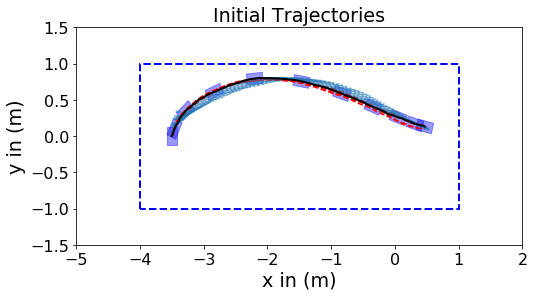

In [549]:
plt.figure(figsize=figsize)
ax = plt.gca()
init_trajs = [x.T for x in x_init_trajs]
plot_experiment(init_trajs, x_init_preds, ax)
plt.title("Initial Trajectories")
print([q[0] for q in init_value_functions])

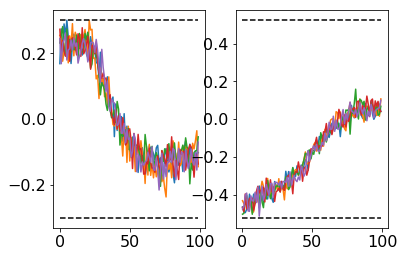

In [550]:
fig, ax = plt.subplots(1,2)
for u_traj in u_init_trajs:
    ax[0].plot(u_traj[:,0])
    ax[1].plot(u_traj[:,1])
for i, lim in enumerate((a_lim, delta_lim)):
    ax[i].plot([lim] * episode_length, "k--")
    ax[i].plot([-lim] * episode_length, "k--")

In [496]:
u_init_trajs[0].shape

(200, 2)

In [497]:
filename = "tracking_mpc"
if save_data:
    experiment_utils.save_result(save_dir, filename, x_init_trajs, u_init_trajs, None, None, None)

## Learning MPC With Local Linear Regression

In [498]:
controller = controllers.LTV_LMPC(A, B, C,
                                     controller_horizon, 
                                     Q,R, state_reference, 
                                     state_constraints, input_constraints)

for x_init_traj, u_init_traj, init_value_func in zip(x_init_trajs, u_init_trajs, init_value_functions):
    controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, init_value_func)

In [499]:
model = system_id.LocalLinearModel(n_states, n_inputs, h, lamb, n_sysid_pts=n_sysid_pts, n_sysid_it=n_sysid_it)
for x_init_traj, u_init_traj in zip(x_init_trajs, u_init_trajs):
    model.add_trajectory(x_init_traj, u_init_traj)

In [500]:
slack_per_episode = []
term_slack_per_episode = []
model_covs_per_episode = []
x_preds_per_episode = []
for episode in range(num_episodes):
    vehicle = get_vehicle()
    
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks, model_covs = sim_traj(vehicle, controller, input_bounds, 
                                                                                     model=model, model_callback=model_callback)
    
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, stage_cost)
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    model.add_trajectory(x_traj, u_traj)
    
    As, Bs, Cs, covs, errors = model.regress_models(x_traj[:controller.N,:], u_traj[:controller.N,:])
    controller.set_models(As, Bs, Cs)
    
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)
    model_covs_per_episode.append(model_covs)
    x_preds_per_episode.append(x_preds)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.38it/s]


Text(0.5,1,'Naive LTV LMPC')

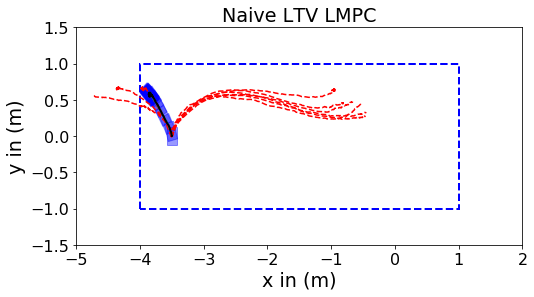

In [501]:
plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list[num_init_episodes:], x_preds, ax)
ax.set_title("Naive LTV LMPC")

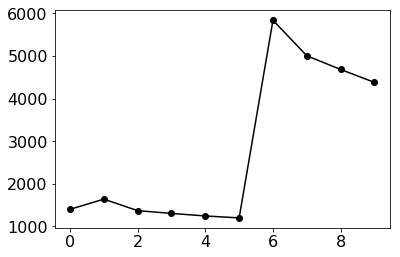

In [502]:
traj_costs = [q[0] for q in controller.value_func_list[num_init_episodes:]]
plt.plot(traj_costs, "k-o")

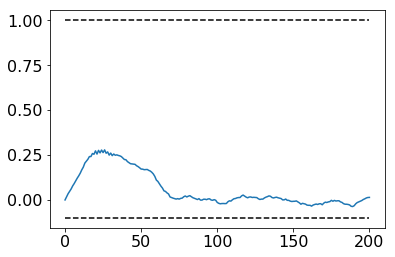

In [503]:
state_vtcs= polytope.extreme(state_limits)
v_max = np.max(state_vtcs[:,-1])
v_min = np.min(state_vtcs[:,-1])
plt.plot(x_traj[:,3])
plt.plot(np.arange(x_traj.shape[0]), np.ones(x_traj.shape[0]) * v_max, "k--")
plt.plot(np.arange(x_traj.shape[0]), np.ones(x_traj.shape[0]) * v_min, "k--")

In [504]:
filename = "naive_ltv_lmpc"
if save_data:
    experiment_utils.save_result(save_dir, filename, controller.traj_list, controller.input_traj_list, x_preds_per_episode, controller.value_func_list, model_covs_per_episode)

## Learning-Based Learning MPC

In [505]:
controller = controllers.LBLMPC(A, B, C,
                                    controller_horizon, 
                                    Q, R, state_reference, 
                                    state_constraints, input_constraints, (disturbance_bound.A, disturbance_bound.b))
## Minimal Invariant Cannot Be Computed
alpha = 10
M = polytope.box2poly([[-db * alpha, db * alpha]] * n_states)
X = polytope.Polytope(*controller.state_constraints)
U = polytope.Polytope(*controller.input_constraints)
X_bar = control_utils.pontryagin_difference(X, M)
U_bar = control_utils.pontryagin_difference(U, control_utils.poly_transform(M, controller.K))
controller.state_constraints = (X_bar.A, X_bar.b)
controller.input_constraints = (U_bar.A, U_bar.b)
controller.init_constraint = (M.A, M.b)

for x_init_traj, u_init_traj, value_function in zip(x_init_trajs, u_init_trajs, init_value_functions):
    x_nominal, u_nominal = control_utils.compute_nominal_traj(x_init_traj.T, u_init_traj.T, A, B, C, controller.K)
    controller.add_trajectory(x_nominal[:,:-1], u_nominal, value_function)

In [506]:
model = system_id.LocalLinearModel(n_states, n_inputs, h, lamb, n_sysid_pts=n_sysid_pts, n_sysid_it=n_sysid_it)
for x_init_traj, u_init_traj in zip(x_init_trajs, u_init_trajs):
    model.add_trajectory(x_init_traj, u_init_traj)

In [507]:
slack_per_episode = []
term_slack_per_episode = []
model_covs_per_episode = []
x_preds_per_episode = []
for episode in range(num_episodes):
    vehicle = get_vehicle()
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks, model_covs = sim_traj(vehicle, controller, input_bounds, 
                                                                                     model=model, model_callback=model_callback)
    
    x_nominal, u_nominal = control_utils.compute_nominal_traj(x_traj.T, u_traj.T, A, B, C, controller.K)
    value_function = control_utils.compute_traj_cost(x_nominal[:,:-1], u_nominal, stage_cost)

    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    model.add_trajectory(x_traj, u_traj)
    
    As, Bs, Cs, covs, errors = model.regress_models(x_traj[:controller.N,:], u_traj[:controller.N,:])
    controller.set_models(As, Bs, Cs)
    
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)
    model_covs_per_episode.append(model_covs)
    x_preds_per_episode.append(x_preds)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:56<00:00,  3.54it/s]


Text(0.5,1,'LBLMPC')

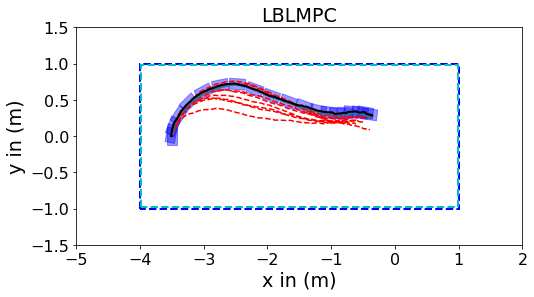

In [508]:
plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list[num_init_episodes:], x_preds, ax)
constraint_tight = X_bar.project([1,2])
constraint_tight.plot(ax=ax, alpha=1, color="w", edgecolor="c", linewidth=2)
ax.set_title("LBLMPC")

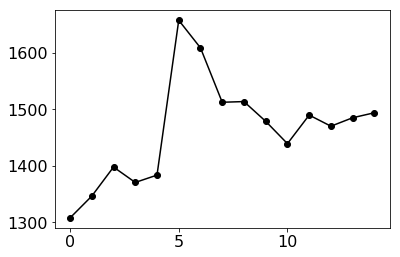

In [509]:
traj_costs = [q[0] for q in controller.value_func_list[:]]
plt.plot(traj_costs, "k-o")

In [510]:
filename = "lblmpc"
if save_data:
    experiment_utils.save_result(save_dir, filename, controller.traj_list, controller.input_traj_list, x_preds_per_episode, controller.value_func_list, model_covs_per_episode)

### LTV LMPC with Local Safe Sets

In [511]:
safe_set_size = 30
n_safe_set_it = 3
controller = controllers.Local_LTV_LMPC(A, B, C,
                                     controller_horizon, 
                                     Q, R, state_reference, 
                                     state_constraints, input_constraints, n_safe_set_it, safe_set_size)
controller.build()
for x_init_traj, u_init_traj, value_function in zip(x_init_trajs, u_init_trajs, init_value_functions):
    controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, value_function)

In [512]:
model = system_id.LocalLinearModel(n_states, n_inputs, h, lamb, n_sysid_pts=n_sysid_pts, n_sysid_it=n_sysid_it)
for x_init_traj, u_init_traj in zip(x_init_trajs, u_init_trajs):
    model.add_trajectory(x_init_traj, u_init_traj)

In [513]:
slack_per_episode = []
term_slack_per_episode = []
model_covs_per_episode = []
x_preds_per_episode = []
for episode in range(num_episodes):
    vehicle = get_vehicle()
    
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks, model_covs = sim_traj(vehicle, controller, input_bounds, 
                                                                                     model=model, model_callback=model_callback)
    
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, stage_cost)
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    model.add_trajectory(x_traj, u_traj)
    
    As, Bs, Cs, covs, errors = model.regress_models(x_traj[:controller.N,:], u_traj[:controller.N,:])
    controller.set_models(As, Bs, Cs)
    
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)
    model_covs_per_episode.append(model_covs)
    x_preds_per_episode.append(x_preds)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:13<00:00, 14.44it/s]


Text(0.5,1,'Local LMPC')

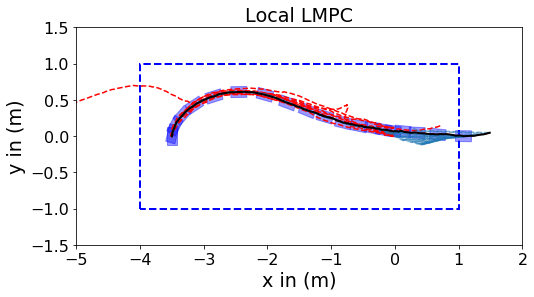

In [514]:
plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list[num_init_episodes:], x_preds, ax)
ax.set_title("Local LMPC") 

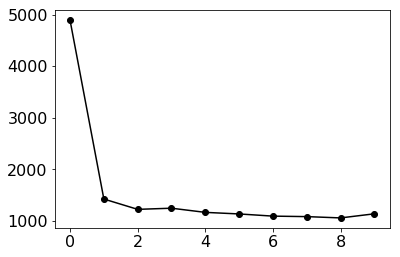

In [515]:
traj_costs = [q[0] for q in controller.value_func_list[num_init_episodes:]]
plt.plot(traj_costs, "k-o")

In [516]:
filename = "local_ltv_lmpc"
if save_data:
    experiment_utils.save_result(save_dir, filename, controller.traj_list, controller.input_traj_list, x_preds_per_episode, controller.value_func_list, model_covs_per_episode)

## True LTV LMPC with Loc Lin Reg

In [517]:
controller = controllers.True_LTV_LMPC(A, B, C,
                                     controller_horizon, 
                                     Q, R, state_reference, 
                                     state_constraints, input_constraints)
for x_init_traj, u_init_traj, value_function in zip(x_init_trajs, u_init_trajs, init_value_functions):
    controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, value_function)

In [518]:
model = system_id.LocalLinearModel(n_states, n_inputs, h, lamb,  n_sysid_pts=n_sysid_pts, n_sysid_it=n_sysid_it)
for x_init_traj, u_init_traj in zip(x_init_trajs, u_init_trajs):
    model.add_trajectory(x_init_traj, u_init_traj)
    
def ltv_model_callback(vehicle, controller, episode_length):
    i = controller.i
    N = controller.N
    i = min(episode_length - N, i)
    x_traj = controller.traj_list[-1][:,i:i+N]
    u_traj = controller.input_traj_list[-1][:,i:i+N]
    As, Bs, Cs, covs, errors = model.regress_models(controller.x_traj.value.T, controller.u_traj.value.T)
    return As, Bs, Cs, covs, errors

In [519]:
slack_per_episode = []
term_slack_per_episode = []
model_covs_per_episode = []
x_preds_per_episode = []
for episode in range(num_episodes):
    vehicle = get_vehicle()
    
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks, model_covs = sim_traj(vehicle, controller, input_bounds, 
                                                                                     model=model, model_callback=ltv_model_callback)
    
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, stage_cost)
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    model.add_trajectory(x_traj, u_traj)
    
    As, Bs, Cs, covs, errors = model.regress_models(x_traj[:controller.N,:], u_traj[:controller.N,:])
    controller.set_models(As, Bs, Cs)
    
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)
    model_covs_per_episode.append(model_covs)
    x_preds_per_episode.append(x_preds)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:14<00:00, 14.17it/s]


Text(0.5,1,'True TV LMPC')

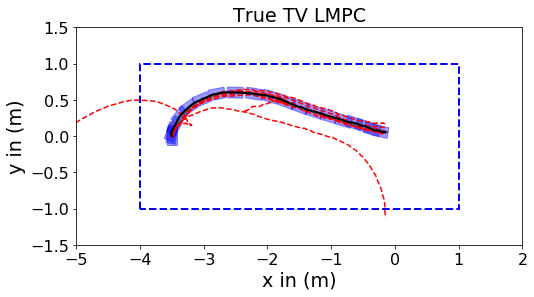

In [520]:
plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list[num_init_episodes:], x_preds, ax)
ax.set_title("True TV LMPC")

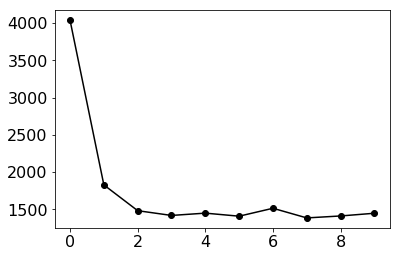

In [521]:
traj_costs = [q[0] for q in controller.value_func_list[num_init_episodes:]]
plt.plot(traj_costs, "k-o" )

In [522]:
filename = "true_ltv_lmpc"
if save_data:
    experiment_utils.save_result(save_dir, filename, controller.traj_list, controller.input_traj_list, x_preds_per_episode, controller.value_func_list, model_covs_per_episode)

## LTI LMPC

In [523]:
controller = controllers.LTI_LMPC(A, B, C,
                                     controller_horizon, 
                                     Q, R, state_reference, 
                                     state_constraints, input_constraints)
for x_init_traj, u_init_traj, value_function in zip(x_init_trajs, u_init_trajs, init_value_functions):
    controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, value_function)

In [524]:
slack_per_episode = []
term_slack_per_episode = []
x_preds_per_episode = []
for episode in range(num_episodes):
    vehicle = get_vehicle()
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks, model_covs = sim_traj(vehicle, controller, input_bounds)
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, stage_cost)
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)
    x_preds_per_episode.append(x_preds)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:26<00:00,  7.60it/s]


Text(0.5,1,'LTI LMPC')

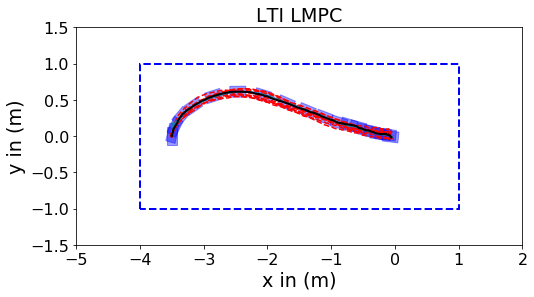

In [525]:
plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list[num_init_episodes:], x_preds, ax)
ax.set_title("LTI LMPC")

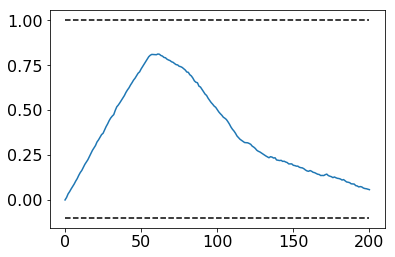

In [526]:
state_vtcs= polytope.extreme(state_limits)
v_max = np.max(state_vtcs[:,-1])
v_min = np.min(state_vtcs[:,-1])
plt.plot(x_traj[:,3])
plt.plot(np.arange(x_traj.shape[0]), np.ones(x_traj.shape[0]) * v_max, "k--")
plt.plot(np.arange(x_traj.shape[0]), np.ones(x_traj.shape[0]) * v_min, "k--")

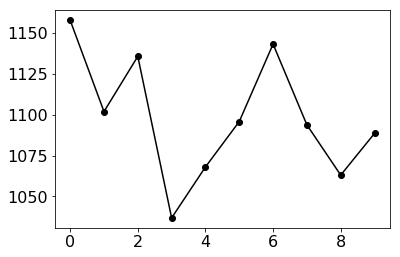

In [527]:
traj_costs = [q[0] for q in controller.value_func_list[num_init_episodes:]]
plt.plot(traj_costs, "k-o" )

In [528]:
filename = "lti_lmpc"
if save_data:
    experiment_utils.save_result(save_dir, filename, controller.traj_list, controller.input_traj_list, x_preds_per_episode, controller.value_func_list, None)

## LTV Tube LMPC

In [529]:
## Minimal Invariant Cannot Be Computed
alpha = 10
M = polytope.box2poly([[-db * alpha, db * alpha]] * n_states)
minimal_invariant = (M.A, M.b)

controller = controllers.LTV_Tube_LMPC(A, B, C,
                                    controller_horizon, 
                                    Q, R, state_reference, 
                                    state_constraints, input_constraints, minimal_invariant)

for x_init_traj, u_init_traj, value_function in zip(x_init_trajs, u_init_trajs, init_value_functions):
    controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, value_function)

In [530]:
model = system_id.LocalLinearModel(n_states, n_inputs, h, lamb, n_sysid_pts=n_sysid_pts, n_sysid_it=n_sysid_it)
for x_init_traj, u_init_traj in zip(x_init_trajs, u_init_trajs):
    model.add_trajectory(x_init_traj, u_init_traj)

In [531]:
slack_per_episode = []
term_slack_per_episode = []
model_covs_per_episode = []
x_preds_per_episode = []
for episode in range(num_episodes):
    vehicle = get_vehicle()
    
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks, model_covs = sim_traj(vehicle, controller, input_bounds, 
                                                                                     model=model, model_callback=model_callback)
    
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, stage_cost)
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    model.add_trajectory(x_traj, u_traj)
    
    As, Bs, Cs, covs, errors = model.regress_models(x_traj[:controller.N,:], u_traj[:controller.N,:])
    controller.set_models(As, Bs, Cs)
    
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)
    model_covs_per_episode.append(model_covs)
    x_preds_per_episode.append(x_preds)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.79it/s]


Text(0.5,1,'LTV Tube LMPC')

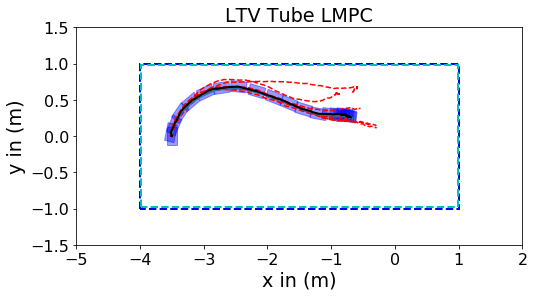

In [532]:
plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list[num_init_episodes:], x_preds, ax)
X_bar = polytope.Polytope(*controller.state_constraints)
constraint_tight = X_bar.project([1,2])
constraint_tight.plot(ax=ax, alpha=1, color="w", edgecolor="c", linewidth=2)
ax.set_title("LTV Tube LMPC")

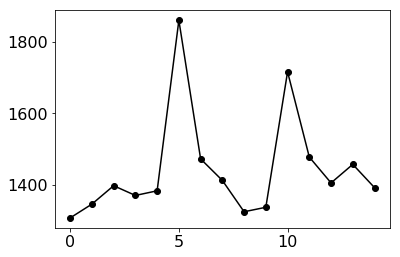

In [535]:
traj_costs = [q[0] for q in controller.value_func_list[num_init_episodes:]]
plt.plot(traj_costs, "k-o" )

In [534]:
filename = "tube_ltv_lmpc"
if save_data:
    experiment_utils.save_result(save_dir, filename, controller.traj_list, controller.input_traj_list, x_preds_per_episode, controller.value_func_list, model_covs_per_episode)

In [551]:
import time

4.505680799484253
